###  Energy Generation Time Series
##### U.S. Electricity Generation (https://www.kaggle.com/datasets/ravishah1/electricity-generation-time-series)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn import preprocessing
import warnings
warnings.simplefilter("ignore", UserWarning)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from scipy import signal
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima 
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score, mean_absolute_percentage_error

In [5]:
us_el_selected=pd.read_csv('us_el_selected.csv',index_col=[0])
us_el_selected['Date']=pd.to_datetime(us_el_selected['Date'])
us_el_selected = us_el_selected.loc[:,:'United States : all sectors']
us_el_selected.set_index('Date', inplace=True)

In [6]:
us_el_selected.head()

,United States : all sectors
Date,
2001-01-01,332493
2001-02-01,282940
2001-03-01,300707
2001-04-01,278079
2001-05-01,300492


In [7]:
train = us_el_selected.loc['2001-01-01':'2020-12-01']
test = us_el_selected.loc['2021-01-01':'2022-03-01']

In [8]:
model =auto_arima(train,seasonal=True, m=12)

In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  240
Model:             SARIMAX(5, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -2688.400
Date:                              Sat, 05 Aug 2023   AIC                           5392.800
Time:                                      14:17:01   BIC                           5420.612
Sample:                                  01-01-2001   HQIC                          5404.007
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0976      0.077     -1.261      0.207      -0.249       0.054
ar.L2         -0.0662      0.078     -0.847      0.397      -0.219       0.087
ar.L3         -0.1670      0.066     -2.514      0.012      -0.297      -0.037
ar.L4         -0.1147      0.042     -2.753      0.006      -0.196      -0.033
ar.L5          0.0075      0.077      0.098      0.922      -0.144       0.159
ar.S.L12       0.9688      0.025     38.748      0.000       0.920       1.018
ma.S.L12      -0.8512      0.061    -13.876      0.000      -0.971      -0.731
sigma2      5.586e+08   5.49e-12   1.02e+20      0.000    5.59e+08    5.59e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                62.78
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.81e+36. Standard errors may be unstable.
"""

In [10]:
predictions=pd.DataFrame(model.predict(n_periods=15),index=test.index, columns=['predictions'])

In [11]:
test.index

DatetimeIndex(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [12]:
predictions

,predictions
Date,
2021-01-01,358142.361172
2021-02-01,324951.885108
2021-03-01,326639.878009
2021-04-01,305785.095370
2021-05-01,328889.078368
2021-06-01,358150.350302
2021-07-01,393548.628474
2021-08-01,388196.503553
2021-09-01,346363.997877


In [13]:
results = pd.concat([us_el_selected, predictions], axis=1)

In [14]:
mape =mean_absolute_percentage_error(y_true=us_el_selected['United States : all sectors'][-15:], y_pred=model.predict(n_periods=15))
r2_score = r2_score(y_true=us_el_selected['United States : all sectors'][-15:], y_pred=model.predict(n_periods=15))
mae = mean_absolute_error(y_true=us_el_selected['United States : all sectors'][-15:], y_pred=model.predict(n_periods=15))
mse = mean_squared_error(y_true=us_el_selected['United States : all sectors'][-15:], y_pred=model.predict(n_periods=15))

print('mape : %5f' %mape)
print('r2_score : %5f' %r2_score)
print('MAE : %5f' %mae)
print('MSE : %5f' %mse)

mape : 0.026177
r2_score : 0.878485
MAE : 9259.687041
MSE : 140005601.091050


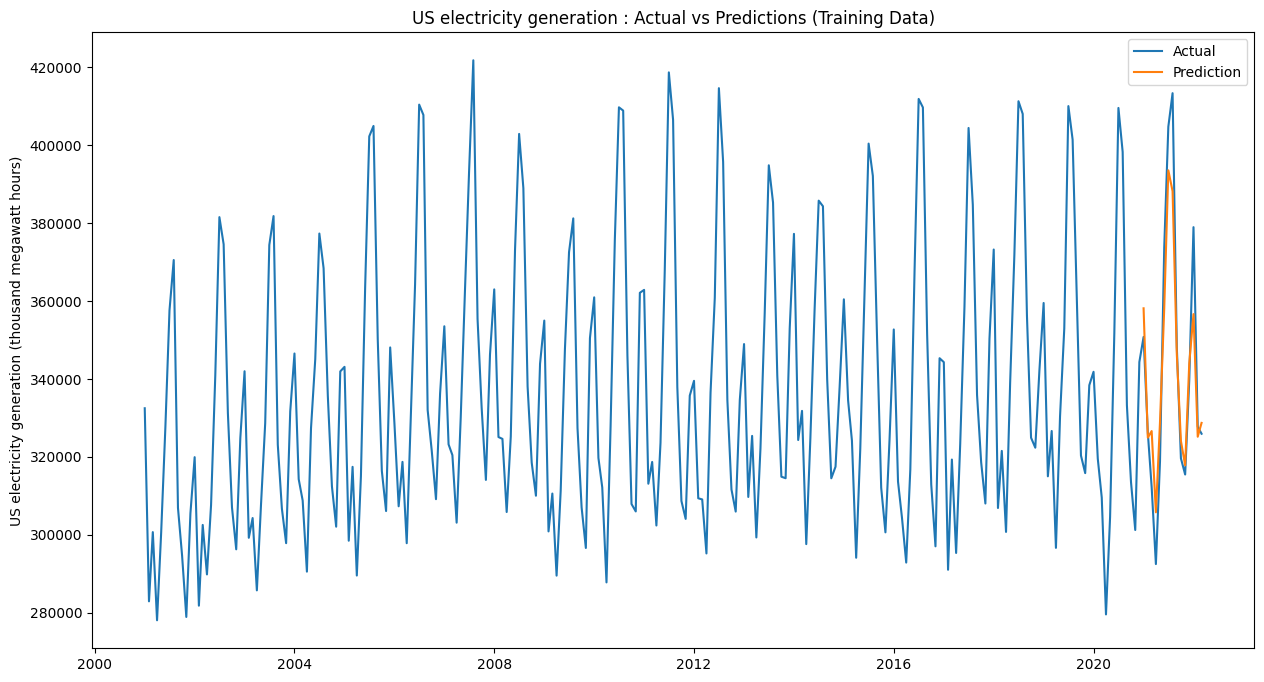

In [15]:
plt.figure(figsize=(15,8))
plt.plot(us_el_selected.index, us_el_selected['United States : all sectors'], label='Actual')
plt.plot(us_el_selected.index[-15:], model.predict(n_periods=15), label='Prediction')
plt.title("US electricity generation : Actual vs Predictions (Training Data)")
plt.ylabel('US electricity generation (thousand megawatt hours)')
plt.legend()
plt.show();

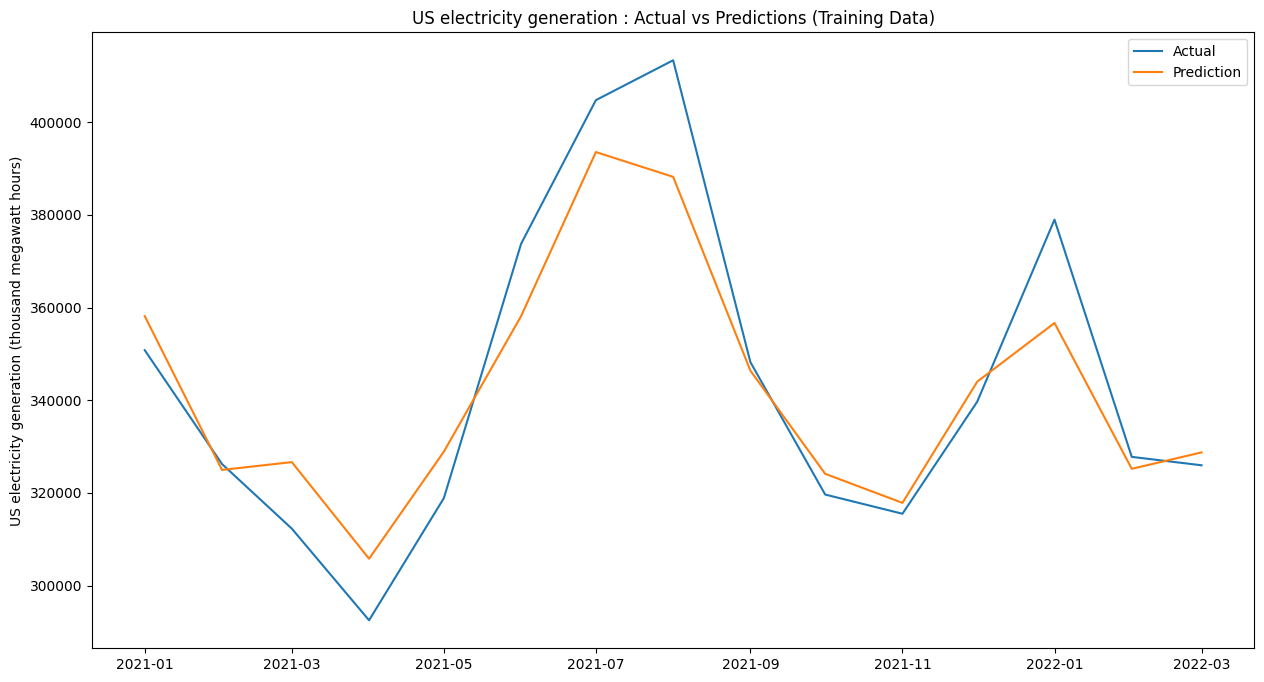

In [16]:
plt.figure(figsize=(15,8))
plt.plot(us_el_selected.index[-15:], us_el_selected['United States : all sectors'][-15:], label='Actual')
plt.plot(us_el_selected.index[-15:], model.predict(n_periods=15), label='Prediction')
plt.title("US electricity generation : Actual vs Predictions (Training Data)")
plt.ylabel('US electricity generation (thousand megawatt hours)')
plt.legend()
plt.show();

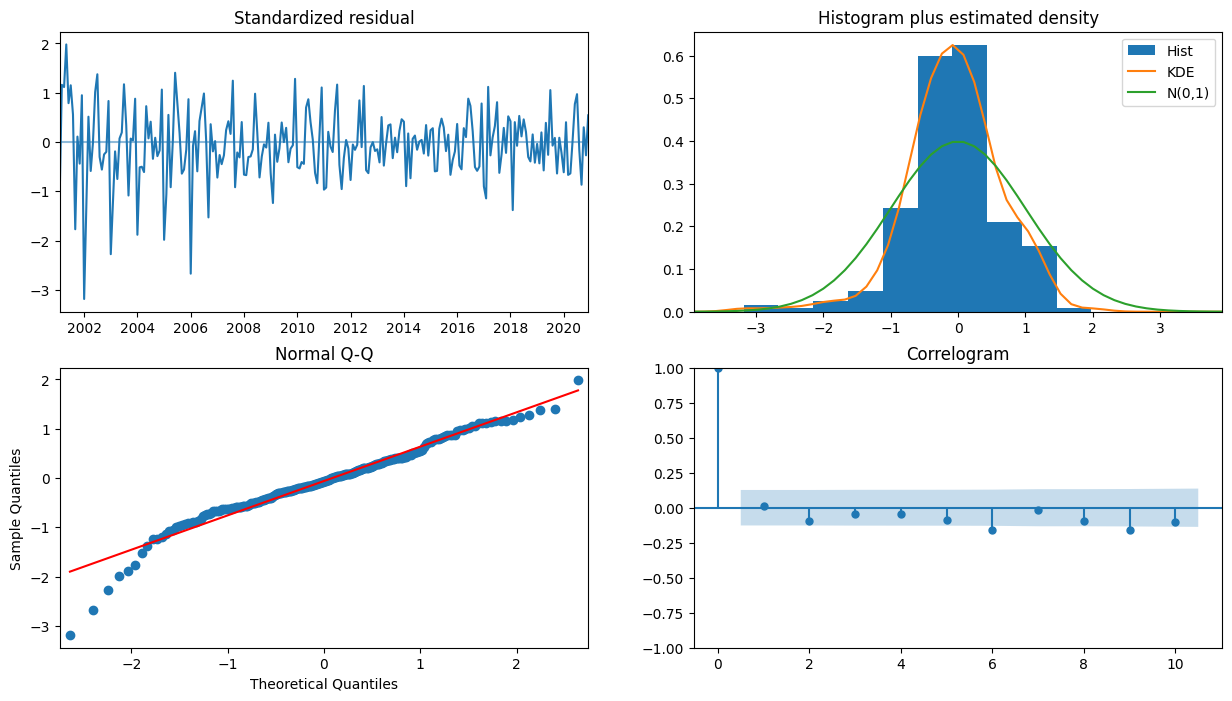

In [22]:
model.plot_diagnostics(figsize=(15,8));

Source/Reference:

https://www.kaggle.com/datasets/ravishah1/electricity-generation-time-series

https://geometrein.medium.com/time-series-forecasting-with-sarimax-c352e4f2012e

https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

https://www.wisdomgeek.com/development/machine-learning/sarima-forecast-seasonal-data-using-python/
